In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from transformers import pipeline


from constants import MODEL_FOLDER_PATH, DATA_FOLDER_PATH

Note: this notebook is adapted from the examples in HuggingFace Audio Corse https://huggingface.co/learn/audio-course/

# 1. Audio data representations

In [3]:
array, sampling_rate = librosa.load(DATA_FOLDER_PATH / "example_tts.wav")

In [4]:
Audio(array, rate=sampling_rate)

### 1.1 Waveform

Samples: 187,245, Sampling rate: 22,050, Duration: 8.49s


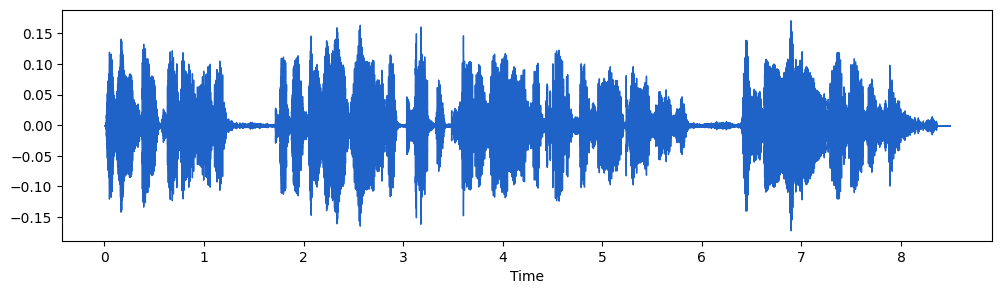

In [5]:
print(f"Samples: {len(array):,}, Sampling rate: {sampling_rate:,}, Duration: {len(array)/sampling_rate:.2f}s")

plt.figure(figsize=(12, 3))
librosa.display.waveshow(array, sr=sampling_rate, color="#1F63C8")

### 1.2 FFT

Text(0.5, 1.0, 'DFT of a segment of the audio signal')

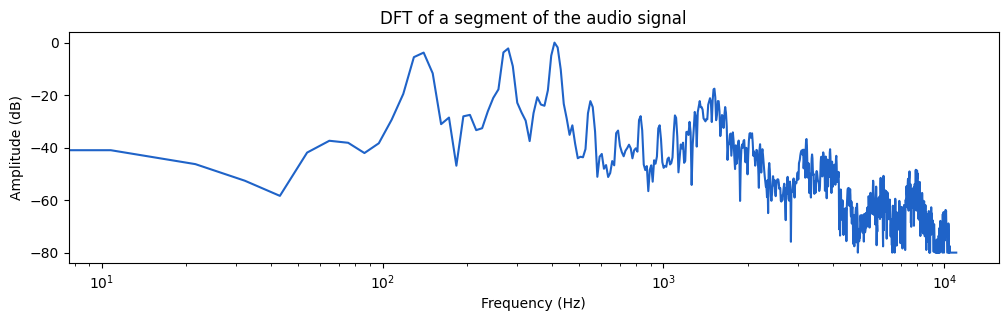

In [6]:
segment = array[:2048]

# compute DFT
dft = np.fft.rfft(np.hanning(len(segment)) * segment)

# get amplitude in dB
dft_amplitude = librosa.amplitude_to_db(np.abs(dft), ref=np.max)

# get frequencies
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(segment))

plt.figure(figsize=(12, 3))
plt.plot(frequency, dft_amplitude, color="#1F63C8")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")
plt.title("DFT of a segment of the audio signal")

### 1.3 Spectrogram

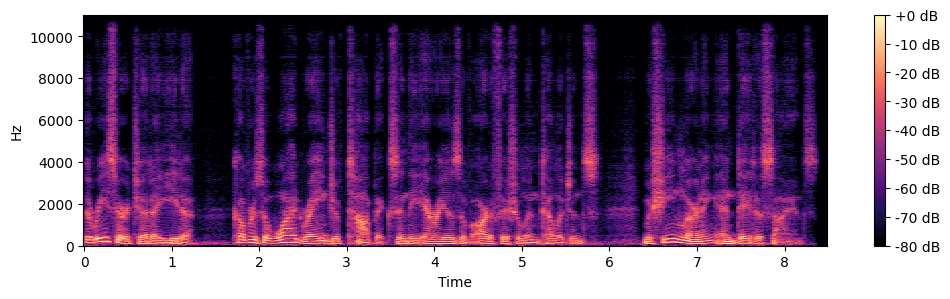

In [7]:
spectrogram_db = librosa.amplitude_to_db(np.abs(librosa.stft(array)), ref=np.max)

plt.figure(figsize=(12, 3))
librosa.display.specshow(spectrogram_db, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")

### 1.4. mel spectrogram

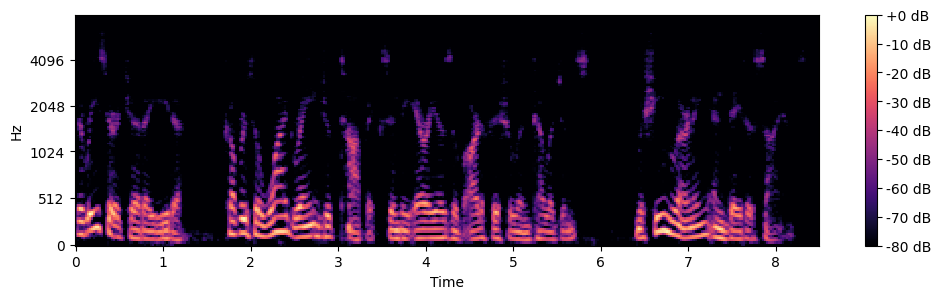

In [8]:
# compute mel spectrogram, number of mel bands = 128, maximum frequency = 8 kHz
mel_spectrogram = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(12, 3))
librosa.display.specshow(mel_spectrogram_db, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar(format="%+2.0f dB")

# 2. Applications

### 2.1 emotion classification

In [9]:
classifier = pipeline("audio-classification", model="superb/hubert-large-superb-er")
classifier(array)

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

[{'score': 0.6816648840904236, 'label': 'sad'},
 {'score': 0.2440345585346222, 'label': 'hap'},
 {'score': 0.07301316410303116, 'label': 'neu'},
 {'score': 0.0012874588137492537, 'label': 'ang'}]

### 2.2 Speech Recognition

In [10]:
asr = pipeline("automatic-speech-recognition", model="openai/whisper-medium")
asr_result = asr(array)
asr_result["text"]

' The research at AIDA covers a wide range of topics in the areas of artificial intelligence, machine learning and data science.'

### 2.3 Text to speech

In [11]:
tts = pipeline("text-to-speech", model="suno/bark-small")
tts_result = tts(asr_result["text"].strip())
Audio(tts_result["audio"][0], rate=tts_result["sampling_rate"])

/home/bkang/ugent_aigc_course_dev/4_audio_generation/ugenai4/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


### 2.4 Voice cloning

In [13]:
import utils

Export newer ffmpeg binary for denoise filter
Make ffmpeg binary executable
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
XTTS downloaded
[2023-11-17 09:23:04,421] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2023-11-17 09:23:04,688] [INFO] [logging.py:96:log_dist] [Rank -1] DeepSpeed info: version=0.11.1, git-hash=unknown, git-branch=unknown
[2023-11-17 09:23:04,690] [WARNING] [config_utils.py:69:_process_deprecated_field] Config parameter replace_method is deprecated. This parameter is no longer needed, please remove from your call to DeepSpeed-inference
[2023-11-17 09:23:04,691] [WARNING] [config_utils.py:69:_process_deprecated_field] Config parameter mp_size is deprecated use tensor_parallel.tp_size instead
[2023-11-17 09:23:04,692] [INFO] [logging.py:96:log_dist] [Rank -1] quantize_bits = 8 mlp_extra_grouping = False, quantize_groups = 1


Using /home/bkang/.cache/torch_extensions/py39_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/bkang/.cache/torch_extensions/py39_cu118/transformer_inference/build.ninja...
Building extension module transformer_inference...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load transformer_inference op: 1.651940107345581 seconds
[2023-11-17 09:23:08,920] [INFO] [logging.py:96:log_dist] [Rank -1] DeepSpeed-Inference config: {'layer_id': 0, 'hidden_size': 1024, 'intermediate_size': 4096, 'heads': 16, 'num_hidden_layers': -1, 'dtype': torch.float32, 'pre_layer_norm': True, 'norm_type': <NormType.LayerNorm: 1>, 'local_rank': -1, 'stochastic_mode': False, 'epsilon': 1e-05, 'mp_size': 1, 'scale_attention': True, 'triangular_masking': True, 'local_attention': False, 'window_size': 1, 'rotary_dim': -1, 'rotate_half': False, 'rotate_every_two': True, 'return_tuple': True, 'mlp_after_attn': True, 'mlp_act_func_type': <ActivationFuncType.GELU: 1>, 'specialized_mode': False, 'training_mp_size': 1, 'bigscience_bloom': False, 'max_out_tokens': 1024, 'min_out_tokens': 1, 'scale_attn_by_inverse_layer_idx': False, 'enable_qkv_quantization': False, 'use_mup': False, 'return_single_tuple': False, 'set_empty_params': False, 'transposed_mode': F

Loading extension module transformer_inference...
Using /home/bkang/.cache/torch_extensions/py39_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module transformer_inference, skipping build step...
Loading extension module transformer_inference...


Time to load transformer_inference op: 0.2905235290527344 seconds


In [16]:
utils.predict(
    asr_result["text"],
    language="en",
    audio_file_pth="./tmp/data/fridman.wav",
    mic_file_path=False,
    use_mic=False,
    voice_cleanup=True,
    no_lang_auto_detect=True,
    agree=True,
)
from IPython.display import Audio
Audio("./output.wav")

Detected language:en, Chosen language:en


ffmpeg version N-67110-g156f53e987-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      58. 24.100 / 58. 24.100
  libavcodec     60. 26.100 / 60. 26.100
  

Filtered microphone input
I: Generating new audio in streaming mode...
Received chunk 0 of audio length 21248
Received chunk 1 of audio length 22272
Received chunk 2 of audio length 22272
Received chunk 3 of audio length 22272
Received chunk 4 of audio length 22272
Received chunk 5 of audio length 22272
Received chunk 6 of audio length 22272
Received chunk 7 of audio length 22272
Received chunk 8 of audio length 22272
Received chunk 9 of audio length 22272
Received chunk 10 of audio length 6656
I: Time to generate audio: 3076 milliseconds
torch.Size([228352])
Real-time factor (RTF): 0.32331037748554897


### 2.5 Music generation

In [17]:
music_pipe = pipeline("text-to-audio", model="facebook/musicgen-small")

/home/bkang/ugent_aigc_course_dev/4_audio_generation/ugenai4/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [22]:
output = music_pipe("Goldberg Variations, BWV 988: Aria style", forward_params={"max_new_tokens": 512})
Audio(output["audio"][0], rate=music_pipe.model.config.audio_encoder.sampling_rate)